# ABS tutorial 01

## basics of `ObservableDict` class

The `ObservableDict` class has three derived sub-classes,
which are `Measurements`, `Covariances` and `Masks`.

The actual data in `ObservableDict` is managed by Python dictionary,
there, we use a dictionary to store numpy.ndarray with a four-string-tuple entry with the convention:
`(name, frequency, HEALPix-Nside, extra-tag)`.
The `HEALPix-Nside` is assigned according to the astrophysical convention,
where HEALPix is taken as the default sky survey pixelization toolkit.

All three sub-classes are equiped with the `append` function,
with two input arguments: a dictionary entry and a piece numpy.ndarray data.
This function updates the given dictionary entry with given new data.

In both `Measurements` and `Covariances` classes we implemented the `apply_mask` function,
with single input argument: a `Masks` object.
This function will scan through the entries in the given `Masks` object,
and multiply the mask value to the data if their entries are identical.
(Note that we have no security check to prevent the repeated masking.)

In case the entry name doesn't match, 
e.g., having mask names following the measurement names,
while the covariance matrix is named differently,
we designed the `apply_mask_drct` function in `Covariances` class,
which has input arguments: entry name and numpy.ndarray mask map.
This direct masking function applys the mask map directly to the covariance matrix with given entry name.

In [1]:
import numpy as np
import healpy as hp
from abspy.tools.observable_dict import ObservableDict, Measurements, Masks, Covariances

### append `list` to `Measurements` object

In [2]:
NSIDE = 8
NPIX = 12*NSIDE**2

Measurements object has type:  <class 'abspy.tools.observable_dict.Measurements'>
Measurements hosting data has type:  <class 'numpy.ndarray'>


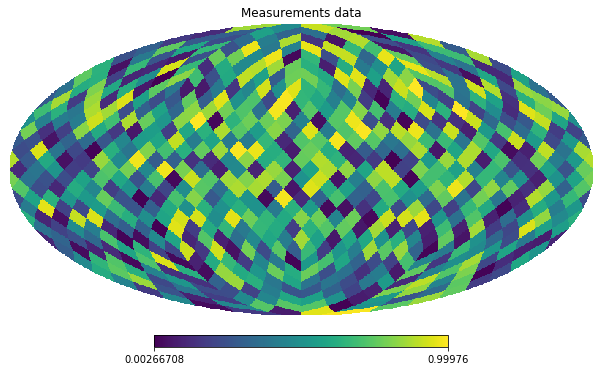

In [3]:
measuredict = Measurements()
# `append` function internally converts any input into numpy.ndarray
measuredict.append(('test', 'nan', str(NSIDE), 'extra'), list(np.random.rand(NPIX)))

print ('Measurements object has type: ',type(measuredict))
data = measuredict[('test', 'nan', str(NSIDE), 'extra')]

print ('Measurements hosting data has type: ',type(data))
hp.mollview(data,title='Measurements data')

### append `numpy.ndarray` to `Masks` object

The `append` function in `Masks` follows the same design as that in `Measurements`.

sky faction:  0.41145833333333337
sky faction:  0.11588541666666663
keys:  dict_keys([('test', 'nan', '8', 'extra'), ('test', 'nan', '8', 'nan')])


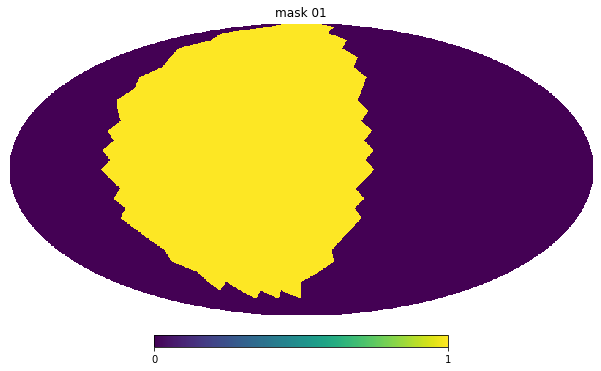

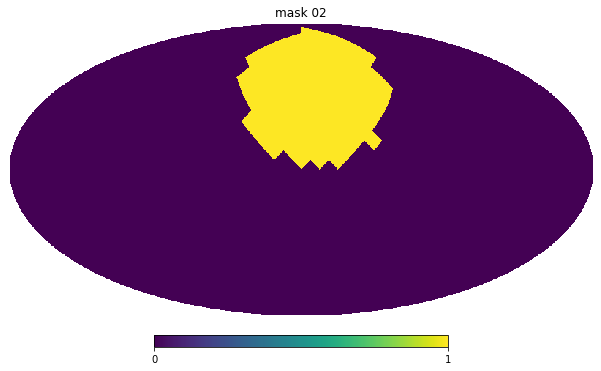

In [4]:
# iso-angular-separation mask generator
def mask_map_prod(nside, clon, clat, sep):
    _c = np.pi/180
    def hav(theta):
        return 0.5-0.5*np.cos(theta)
    _tmp = np.ones(hp.nside2npix(nside),dtype=bool)
    _count = 0
    for _ipix in range(len(_tmp)):
        _lon,_lat = hp.pix2ang(nside,_ipix,lonlat=True)
        # iso-angle separation
        if((hav(np.fabs(clat-_lat)*_c)+np.cos(clat*_c)*np.cos(_lat*_c)*hav(np.fabs(clon-_lon)*_c))>hav(sep*_c)):
            _count = _count + 1
            _tmp[_ipix] = False
    print ('sky faction: ', (1 - _count/(12*nside*nside)))
    return _tmp

maskdict = Masks()
mask01 = mask_map_prod(NSIDE, 40, 10, 80)
maskdict.append(('test', 'nan', str(NSIDE), 'extra'), mask01)
mask02 = mask_map_prod(NSIDE, 350, 40, 40)
maskdict.append(('test', 'nan', str(NSIDE), 'nan'), mask02)

print ('keys: ',maskdict.keys())
hp.mollview(mask01,title='mask 01')
hp.mollview(mask02,title='mask 02')

### append `numpy.ndarray` to `Covariances` object

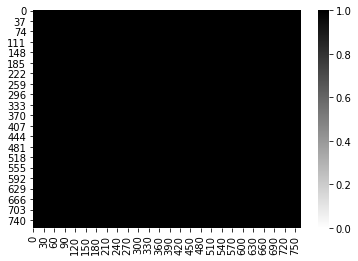

In [5]:
test_cov = np.ones((NPIX,NPIX), dtype=np.float64)
covdict = Covariances()
covdict.append(('test', 'nan', str(NSIDE), 'extra'), test_cov)

# visualize
import seaborn as sns
sns.heatmap(covdict[('test', 'nan', str(NSIDE), 'extra')], cmap='binary', vmin=0, vmax=1)

### apply `Masks` object to `Measurements` and `Covariances` objects

We also illustrate the usage of `apply_mask_drct` function.

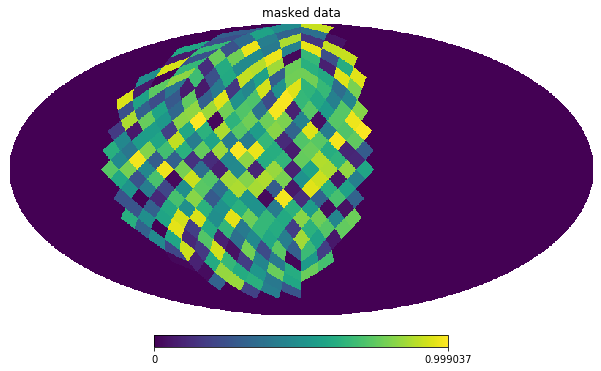

In [6]:
measuredict.apply_mask(maskdict)
hp.mollview(measuredict[('test', 'nan', str(NSIDE), 'extra')],title='masked data')

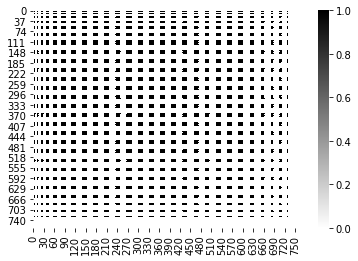

In [7]:
covdict.apply_mask(maskdict)
sns.heatmap(covdict[('test', 'nan', str(NSIDE), 'extra')], cmap='binary', vmin=0, vmax=1)

The 2nd masking operation acts on top of the 1st masking.

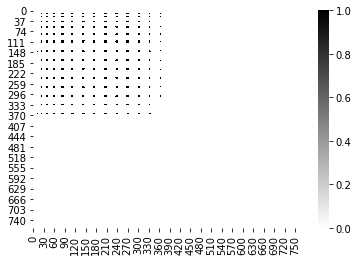

In [8]:
covdict.apply_mask_drct(('test', 'nan', str(NSIDE), 'extra'), maskdict[('test', 'nan', str(NSIDE), 'nan')])
sns.heatmap(covdict[('test', 'nan', str(NSIDE), 'extra')], cmap='binary', vmin=0, vmax=1)

end